# **NLP Financial News Classification**
---

This notebook compiles the code for our group project, which focuses on financial news classification. The project addresses a critical challenge in financial markets: the overwhelming volume of news, which makes it difficult for analysts, investors, and decision-makers to identify and focus on the most relevant and impactful information. By leveraging natural language processing (NLP) techniques, this project aims to categorize financial news into meaningful topics, enabling users to efficiently filter and analyze information for better decision-making.

## Table of Contents
---
1. [Import Required Libraries](#Import-Required-Libraries)
2. [Load the Dataset](#Load-the-Dataset)
3. [Data Handling](#Data-Handling)
4. [Preprocessing](#Preprocessing)
    - [4.1 Define the preprocessing utility functions](#41-Define-the-preprocessing-utility-functions)
    - [4.2 Perform the preprocessing](#42-Perform-the-preprocessing)
    - [4.3 Preliminary data exploration](#43-Preliminary-data-exploration)
    - [4.4 Feature engineering](#44-Feature-engineering)
    - [4.5 Preliminary statistical analysis and feasibility study](#45-Preliminary-statistical-analysis-and-feasibility-study)
    - [4.6 Feature selection](#46-Feature-selection)
5. [Machine Learning Models](#Machine-Learning-Models)

## 1. Import Required Libraries:
---

In [ ]:
# !pip install swifter
# !pip install scikit-learn
# !pip install num2words autocorrect datasets
# !pip -q install datasets num2words autocorrect

In [ ]:
import re
import time
import scipy
import torch
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from num2words import num2words
from autocorrect import Speller
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
import sklearn.linear_model as lm
from torch.utils.data import DataLoader
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from datasets import concatenate_datasets


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 2. Load the Dataset
---

The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their topic.

The dataset holds 21,107 documents annotated with 20 labels.

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from datasets import load_dataset

ds = load_dataset("zeroshot/twitter-financial-news-topic")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

topic_train.csv:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

topic_valid.csv:   0%|          | 0.00/580k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16990 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4117 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16990
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4117
    })
})

In [ ]:
ds[list(ds.keys())[0]][:5]

{'text': ["Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh",
  'Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says  https://t.co/fLS2w57iCz',
  'Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition  https://t.co/1EmtywmYpr',
  "Analysts react to Tesla's latest earnings, break down what's next for electric car maker  https://t.co/kwhoE6W06u",
  'Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside  https://t.co/jPpdl0D9s4'],
 'label': [0, 0, 0, 0, 0]}

## 3. Data Handling
---

HuggingFace originally split the dataset in to two subsets, train and validation.
We are concatenating them and later we will split them with a ratio of our choice.

In [ ]:
first_df = pd.DataFrame(ds["train"])
second_df = pd.DataFrame(ds["validation"])
dataset_df = pd.concat([first_df, second_df]).reset_index(drop=True)
dataset_df = dataset_df.rename(columns={"label": "_label_"})

In [ ]:
dataset_df.head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,"Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon & more https://t.co/QPN8Gwl7Uh",0
1,"Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says https://t.co/fLS2w57iCz",0
2,"Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition https://t.co/1EmtywmYpr",0
3,"Analysts react to Tesla's latest earnings, break down what's next for electric car maker https://t.co/kwhoE6W06u",0
4,"Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside https://t.co/jPpdl0D9s4",0
5,Barclays believes earnings for these underperforming stocks may surprise Wall Street https://t.co/PHbsyVGAyE,0
6,"Bernstein upgrades Alibaba, says shares can rally more than 20% from here https://t.co/m3ApoPRGU0",0
7,"Analysts react to Netflix's strong quarter, with some pointing to a potential bottom for the stock https://t.co/cQngJsyefD",0
8,"Buy Chevron as shares look attractive at these levels, HSBC says https://t.co/GkDpFvxjEP",0
9,Morgan Stanley says these global stocks are set for earnings beats — and gives one over 45% upside https://t.co/GeWxa5YoWr,0


In [ ]:
# original labels
topics_numeric = {
    0: "Analyst Update",
    1: "Fed | Central Banks",
    2: "Company | Product News",
    3: "Treasuries | Corporate Debt",
    4: "Dividend",
    5: "Earnings",
    6: "Energy | Oil",
    7: "Financials",
    8: "Currencies",
    9: "General News | Opinion",
    10: "Gold | Metals | Materials",
    11: "IPO",
    12: "Legal | Regulation",
    13: "M&A | Investments",
    14: "Macro",
    15: "Markets",
    16: "Politics",
    17: "Personnel Change",
    18: "Stock Commentary",
    19: "Stock Movement",
}

dataset_df["_topic_name_"] = dataset_df["_label_"].map(topics_numeric)
# dataset_df[["_label_", "_topic_name_"]].head()
dataset_df.head()

,text,_label_,_topic_name_
0,Here are Thursday's biggest analyst calls: App...,0,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,0,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",0,Analyst Update
4,Netflix and its peers are set for a ‘return to...,0,Analyst Update


In [ ]:
# Distribution of original labels:
label_counts = dataset_df["_label_"].value_counts(ascending=False)
distribution_df = label_counts.reset_index()
# distribution_df.columns = ["_label_", "count"]  # Rename the columns properly
distribution_df["_topic_name_"] = distribution_df["_label_"].map(topics_numeric)
distribution_df = distribution_df[["_label_", "_topic_name_", "count"]]
distribution_df

,_label_,_topic_name_,count
0,2,Company | Product News,4397
1,18,Stock Commentary,2646
2,14,Macro,2237
3,9,General News | Opinion,1893
4,16,Politics,1234
5,5,Earnings,1229
6,1,Fed | Central Banks,1051
7,19,Stock Movement,1020
8,7,Financials,784
9,6,Energy | Oil,670


##### Create a bar plot to view initial topic distribution

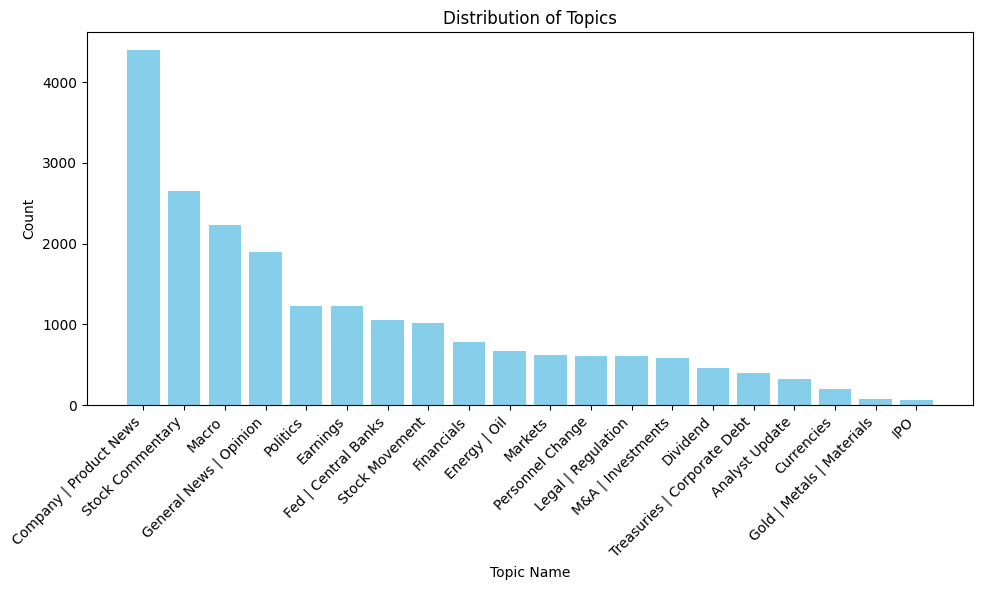

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(distribution_df["_topic_name_"], distribution_df["count"], color='skyblue')
plt.xlabel("Topic Name")
plt.ylabel("Count")
plt.title("Distribution of Topics")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4. Preprocessing
---

### 4.1 Define the preprocessing utility functions
---

In [ ]:
################################################################################
# digits_to_words
# Convert string digits to the English words. The function distinguishes between
#  cardinal and ordinal. E.g. "2" becomes "two", while "2nd" becomes "second"
################################################################################
def digits_to_words(match):
  suffixes = ['st', 'nd', 'rd', 'th']
  string = match[0].lower()
  if string[-2:] in suffixes:
    type='ordinal'
    string = string[:-2]
  else:
    type='cardinal'
  return num2words(string, to=type)

################################################################################
# spelling_correction
# Replace misspelled words with the correct spelling.
################################################################################
def spelling_correction(text):
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)

################################################################################
# remove_stop_words
################################################################################
def remove_stop_words(text):
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])

################################################################################
# stemming
# Perform stemming of each word individually.
################################################################################
def stemming(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

################################################################################
# lemmatizing
# Perform lemmatization fOR each word individually.
################################################################################
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

################################################################################
# preprocessing
# This function represents a complete pipeline for text preprocessing.
################################################################################
def preprocessing(input_text):
  output = input_text
  output = output.lower()
  output = re.sub(r'http\S+', "", output)
  output = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, output, flags=re.IGNORECASE)
  output = re.sub('[^ A-Za-z0-9]+', '', output)
  output = spelling_correction(output)
  output = remove_stop_words(output)
  output = stemming(output)
  output = lemmatizing(output)
  return output

### 4.2 Perform the preprocessing
---

In [ ]:
dataset_df["text"] = [preprocessing(text) for text in dataset_df["text"]]

In [ ]:
dataset_df.head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_,_topic_name_
0,thursday biggest analyst call appl amazon tesla planter focus exon amp,0,Analyst Update
1,buy la vega sand travel singapor build well cargo say,0,Analyst Update
2,piper handler downgrad focus sell cite elev risk amid ceo transit,0,Analyst Update
3,analyst react tesla latest earn break what next electr car maker,0,Analyst Update
4,netflix peer set return growth analyst say give one stock one hundr twenti upsid,0,Analyst Update
5,barclay believ earn underperform stock may surpris wall street,0,Analyst Update
6,einstein upgrad alabama say share ralli twenti,0,Analyst Update
7,analyst react netflix strong quarter point potenti bottom stock,0,Analyst Update
8,buy chevron share look attract level hsbc say,0,Analyst Update
9,morgan stanley say global stock set earn beat give one fortyf upsid,0,Analyst Update


### 4.3 Preliminary data exploration
---

The objective is to explore the nature of the data, and to study whether there is a connection between the "X" data ('tweets' text) and the desired value, "Y" (classifying the topic).
We start by looking at the length of each tweet.

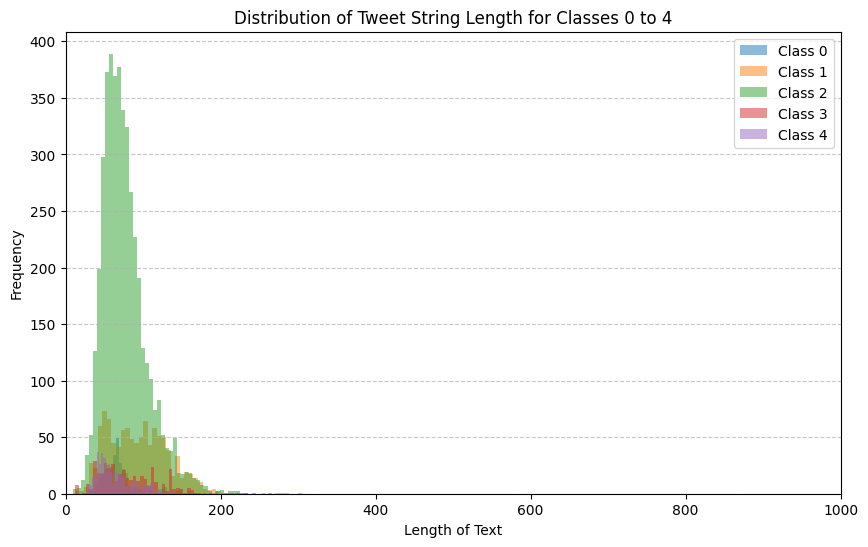

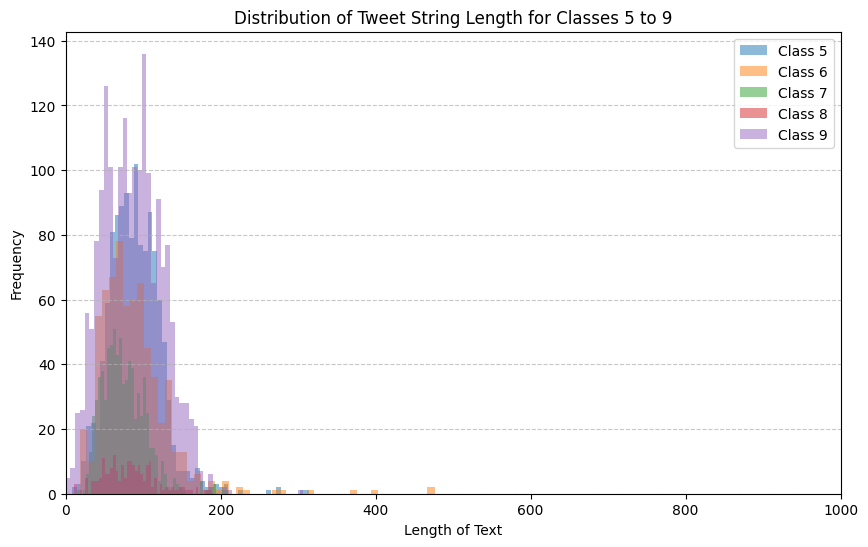

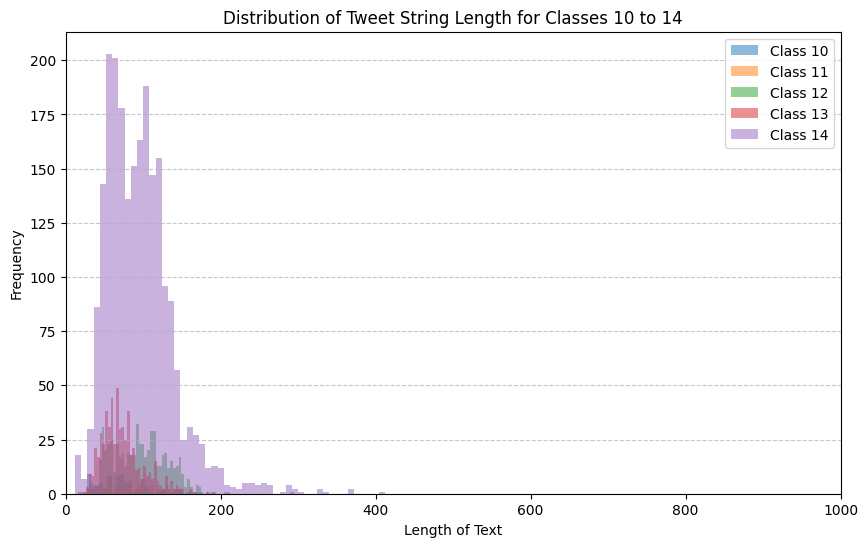

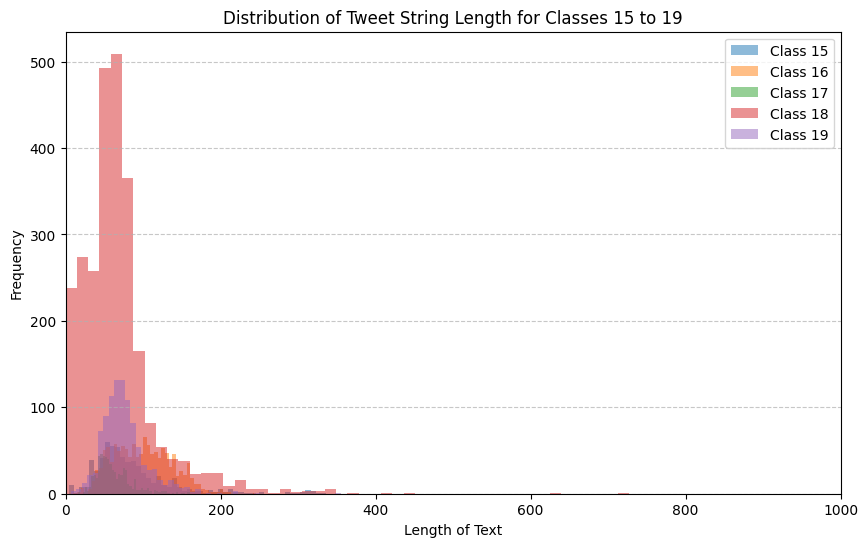

In [ ]:
dataset_df["length of text"] = dataset_df["text"].map(len)
labels = dataset_df["_label_"].unique()
labels.sort()
label_groups = [labels[i:i + 5] for i in range(0, len(labels), 5)]

for i, group in enumerate(label_groups):
    plt.figure(figsize=(10, 6))
    for label in group:
        subset = dataset_df[dataset_df["_label_"] == label]
        plt.hist(
            subset["length of text"],
            bins=50,
            alpha=0.5,
            label=f"Class {label}"
        )
    plt.title(f"Distribution of Tweet String Length for Classes {group[0]} to {group[-1]}")
    plt.xlabel("Length of Text")
    plt.ylabel("Frequency")
    plt.legend()
    plt.xlim([0, 1000])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### 4.4 Feature engineering
---

In [ ]:
# Parameters for CountVectorizer
feature_eng_details = "CountVectorizer-binary"  # Options: "CountVectorizer-binary" or "CountVectorizer-BOW"
ngram_range_min = 1
ngram_range_max = 2
max_features = 1000

# Select feature engineering method
if feature_eng_details == "CountVectorizer-binary":
    print("Feature Engineering method: Binary (one-hot encoding)")
    countvectorizer = CountVectorizer(
        ngram_range=(ngram_range_min, ngram_range_max),
        stop_words="english",
        max_features=max_features,
        binary=True,
    )
elif feature_eng_details == "CountVectorizer-BOW":
    print("Feature Engineering method: Bag of Words")
    countvectorizer = CountVectorizer(
        ngram_range=(ngram_range_min, ngram_range_max),
        stop_words="english",
        max_features=max_features,
        binary=False,
    )

out_arr = countvectorizer.fit_transform(dataset_df["text"])
count_tokens = countvectorizer.get_feature_names_out()
out_df = pd.DataFrame(data=out_arr.toarray(), columns=count_tokens)
out_df["_label_"] = dataset_df["_label_"].reset_index(drop=True)

Feature Engineering method: Binary (one-hot encoding)


#### Exploring the new numerical features

In [ ]:
out_df.head()

,aap,ab,acceler,access,accord,account,acquir,acquisit,act,action,...,yield,york,yy,zero,zerof,zerofour,zeroseven,zerothre,zerotwo,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
out_df.describe().loc[['min', 'max', 'mean']]

,aap,ab,acceler,access,accord,account,acquir,acquisit,act,action,...,yield,york,yy,zero,zerof,zerofour,zeroseven,zerothre,zerotwo,_label_
min,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,19.000000
mean,0.00379,0.003269,0.006254,0.00398,0.016724,0.003553,0.008149,0.008054,0.002748,0.008338,...,0.008386,0.006917,0.003316,0.004833,0.00379,0.004785,0.003459,0.003411,0.004548,9.536031


### 4.5 Preliminary statistical analysis and feasibility study
---

This process measures the relationship between "X" and "Y" to see if there is a "correlation".

Since neither X nor Y are numerical in their nature, we seek to evaluate the statistical dependence between them, so to know whether a model would have any "signal" to pick up on.

#### Split to Train/Test

In [ ]:
dataset_test = out_df.sample(frac=0.2,random_state=0)
dataset_train = out_df.drop(dataset_test.index)

#### Calculation P(feature | class)

In [ ]:
means_by_class = dataset_train.groupby(by=["_label_"]).mean().T.sort_index()
means_by_class.head()

_label_,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
aap,0.01145,0.000000,0.002830,0.000000,0.00000,0.001013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007968,0.000000,0.000000,0.012,0.000000,0.000000,0.017355,0.007264
ab,0.00000,0.000000,0.000283,0.000000,0.00277,0.025329,0.000000,0.025723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001109,0.000,0.000000,0.004228,0.001876,0.001211
acceler,0.00000,0.026379,0.011319,0.009494,0.00000,0.001013,0.005587,0.001608,0.019481,0.002007,0.000000,0.000000,0.000000,0.013072,0.009429,0.004,0.001027,0.008457,0.001407,0.004843
access,0.00000,0.008393,0.009055,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.005351,0.000000,0.000000,0.009960,0.002179,0.003328,0.000,0.007187,0.002114,0.000000,0.001211
accord,0.00000,0.028777,0.004527,0.031646,0.00000,0.000000,0.046555,0.004823,0.012987,0.027425,0.044118,0.021277,0.015936,0.004357,0.061009,0.012,0.027721,0.000000,0.001876,0.001211


#### Calculation the ratio that reflects statistical dependence: P(feature | class)/P(feature)

In [ ]:
P_class = sorted([[c, np.mean(out_df["_label_"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(out_df[f] > 0)] for f in out_df.columns if f != "_label_"])
P_feature_inv = [[f, 1/p] for f, p in P_feature]

P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
# Multiplying a "column vector" of feature probablities with a "line vector" of
# class probilities to get a matrix where each element is a product of probabilities:
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))

P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    # Right hand side: P(feature | class) / P(feature)
    P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)
<ipython-input-24-a0e50dfda95d>:16: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)
<ipython-input-24-a0e50dfda95d>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  P_cl

#### The terms that are most indicative of class "1"

In [ ]:
P_class_given_feature.sort_values([1], ascending=False)[[1]].head(10)

_label_,1
ecb,16.150598
central bank,15.018937
governor,14.985091
rais rate,14.763090
central,13.654964
monetari,13.475770
fed,13.291332
hike,12.188283
feder reserv,12.161061
tighten,12.065515


### 4.6 Feature selection
---

This is a univariate feature selection process. It is based on conditional dependence between a feature being 0/1 and a class being 0/1, thus the mean value of the feature is its probability.
The process of feature selection is done on the training set. For each class, we choose the most indicative features. Either maximize the:

* a-priori distribution P(feature | class), Max Liklihood
or
* a posteriori P(class | feature), MAP

In [ ]:
chosen_features = []
classes = means_by_class.columns
for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:200 + 1])

chosen_features = list(set(chosen_features))

In [ ]:
chosen_features

['earli',
 'return',
 'fall',
 'invest market',
 'offici',
 'stock invest',
 'stock busi',
 'squeez',
 'technic',
 'pace',
 'bid',
 'cpi',
 'ford',
 'green',
 'billion',
 'gdp',
 'busi stockmarket',
 'region',
 'lower',
 'asia',
 'budget',
 'comp dia',
 'asset',
 'earn present',
 'sanction',
 'sri',
 'hear',
 'investor',
 'sourc say',
 'stake',
 'fine',
 'putin',
 'strong',
 'result earn',
 'financi result',
 'act',
 'emerg',
 'becom',
 'close',
 'px',
 'thousand twentythre',
 'breakout',
 'bln',
 'lanka',
 'stockmarket economi',
 'manufactur',
 'reach',
 'amid',
 'nongaap',
 'ago',
 'phase',
 'aggress',
 'news',
 'billionair',
 'develop',
 'rule',
 'countri',
 'bori johnson',
 'annual',
 'focus',
 'transit',
 'nord stream',
 'inflat data',
 'minist',
 'encourag investor',
 'battl',
 'come',
 'ea',
 'china',
 'financ market',
 'feder reserv',
 'itali',
 'form',
 'base',
 'commod',
 'ga price',
 'execut',
 'amazon',
 'studi',
 'attract',
 'senat',
 'expans',
 'inform',
 'know',
 'direct

#### Leave only chosen features

Now that we deduced which features are "important" based on the train set, we select them for both the train set and the test set.

In [ ]:
dataset_train_selected = dataset_train.filter(chosen_features + ["_label_"])
dataset_test_selected = dataset_test.filter(chosen_features + ["_label_"])
dataset_train_selected.head()

,earli,return,fall,invest market,offici,stock invest,stock busi,squeez,technic,pace,...,trade financ,administr,parti,round,si,list,merger,regulatori,best,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset_train_selected["_label_"].value_counts()

,count
_label_,
2,3534
18,2132
14,1803
9,1495
5,987
16,974
1,834
19,826
7,622


In [ ]:
label_counts = dataset_train_selected["_label_"].value_counts(ascending=False)
distribution_df_sel = label_counts.reset_index()
distribution_df_sel.columns = ["_label_", "count"]
# Rename the columns properly
distribution_df_sel["_topic_name_"] = distribution_df["_label_"].map(topics_numeric)
distribution_df_sel = distribution_df_sel[["_label_", "_topic_name_", "count"]]
distribution_df_sel

,_label_,_topic_name_,count
0,2,Company | Product News,3534
1,18,Stock Commentary,2132
2,14,Macro,1803
3,9,General News | Opinion,1495
4,5,Politics,987
5,16,Earnings,974
6,1,Fed | Central Banks,834
7,19,Stock Movement,826
8,7,Financials,622
9,6,Energy | Oil,537


##### Check the ditribution of selected topics

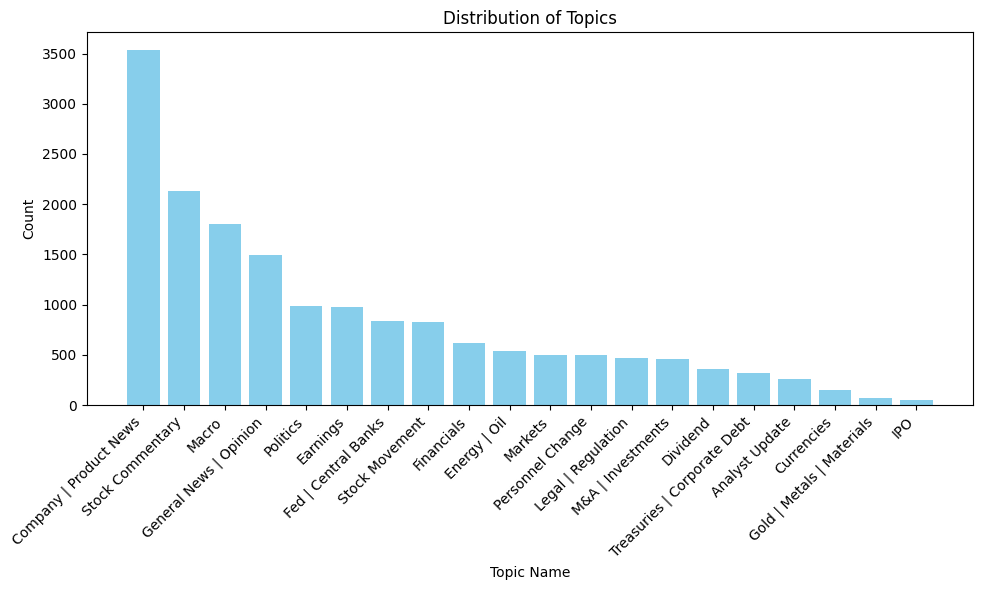

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(distribution_df_sel["_topic_name_"], distribution_df_sel["count"], color='skyblue')
plt.xlabel("Topic Name")
plt.ylabel("Count")
plt.title("Distribution of Topics")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Parse out the Y labels from the dataset, and change the variable type to suit the ML models.

In [ ]:
x_features_train = dataset_train_selected.values[:, 0:-1]
y_labels_train = dataset_train_selected.values[:, -1]

x_features_test = dataset_test_selected.values[:, :-1]
y_labels_test = dataset_test_selected.values[:, -1]

In [ ]:
# # Save training features and labels
# np.savetxt("x_features_train.csv", x_features_train, delimiter=",")
# np.savetxt("y_labels_train.csv", y_labels_train, delimiter=",", fmt='%d')  # Assuming labels are integers

# # Save testing features and labels
# np.savetxt("x_features_test.csv", x_features_test, delimiter=",")
# np.savetxt("y_labels_test.csv", y_labels_test, delimiter=",", fmt='%d')

## 5. Machine Learning Models
---

#### Load the train and test data from preprocessing and feature engineering

In [ ]:
# # Load training features and labels
# x_features_train = np.loadtxt("x_features_train.csv", delimiter=",")
# y_labels_train = np.loadtxt("y_labels_train.csv", delimiter=",", dtype=int)

# # Load testing features and labels
# x_features_test = np.loadtxt("x_features_test.csv", delimiter=",")
# y_labels_test = np.loadtxt("y_labels_test.csv", delimiter=",", dtype=int)

### Model 1: Support Vector Machine (SVM)

In [ ]:
class SVMTrainingPipeline:

    def __init__(self, x_features_train, y_labels_train, x_features_test, y_labels_test, batch_size=64, kernel='linear', C=1.0):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size = batch_size
        self.kernel = kernel
        self.C = C

        self.prepare_data(x_features_train, y_labels_train, x_features_test, y_labels_test)
        self.init_model()

    # prepares the data by standardizing features and creating DataLoaders
    def prepare_data(self, x_features_train, y_labels_train, x_features_test, y_labels_test):

        self.num_classes = len(set(y_labels_train))  # Number of unique labels

        # Standardize features
        self.scaler = StandardScaler()
        x_features_train_scaled = self.scaler.fit_transform(x_features_train)
        x_features_test_scaled = self.scaler.transform(x_features_test)

        # Convert to tensors for compatibility
        self.train_data = TensorDataset(
            torch.tensor(x_features_train_scaled, dtype=torch.float32),
            torch.tensor(y_labels_train, dtype=torch.long)
        )
        self.test_data = TensorDataset(
            torch.tensor(x_features_test_scaled, dtype=torch.float32),
            torch.tensor(y_labels_test, dtype=torch.long)
        )

        # Create DataLoaders for batch processing
        self.train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

    # initializes model
    def init_model(self):
        self.model = SVC(kernel=self.kernel, C=self.C, decision_function_shape='ovo')

    # trains the SVM model
    def train(self):
        # Collect all data points from DataLoader for SVM training
        X_train = []
        y_train = []
        for features, labels in self.train_loader:
            X_train.append(features.numpy())
            y_train.append(labels.numpy())

        # Flatten the collected data
        X_train = torch.cat([torch.tensor(f) for f in X_train], dim=0).numpy()
        y_train = torch.cat([torch.tensor(l) for l in y_train], dim=0).numpy()

        # Fit the SVM model
        self.model.fit(X_train, y_train)
        print("SVM Training Completed.")

    # evaluate(): Evaluates the model on the test data and prints the metrics
    def evaluate(self):

        # Collect all data points from DataLoader for SVM evaluation
        X_test = []
        y_test = []
        for features, labels in self.test_loader:
            X_test.append(features.numpy())
            y_test.append(labels.numpy())

        # Flatten the collected data
        X_test = torch.cat([torch.tensor(f) for f in X_test], dim=0).numpy()
        y_test = torch.cat([torch.tensor(l) for l in y_test], dim=0).numpy()

        # Predict
        y_pred = self.model.predict(X_test)

        # Calculate metrics
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)

        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'Accuracy: {accuracy:.4f}')

        # Print metrics for each label/class
        print("\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

In [ ]:
pipeline_SVM = SVMTrainingPipeline(x_features_train, y_labels_train, x_features_test, y_labels_test)

In [ ]:
pipeline_SVM.train()

SVM Training Completed.


In [ ]:
pipeline_SVM.evaluate()

Precision: 0.7361
Recall: 0.7316
F1 Score: 0.7310
Accuracy: 0.7316

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.6197    0.6667    0.6423        66
           1     0.7564    0.8157    0.7849       217
           2     0.7247    0.7625    0.7431       863
           3     0.6977    0.7317    0.7143        82
           4     0.9495    0.9895    0.9691        95
           5     0.8488    0.9050    0.8760       242
           6     0.6558    0.7594    0.7038       133
           7     0.8107    0.8457    0.8278       162
           8     0.4722    0.7727    0.5862        44
           9     0.6296    0.5980    0.6134       398
          10     0.2812    0.6429    0.3913        14
          11     0.6000    0.2727    0.3750        11
          12     0.7196    0.7404    0.7299       104
          13     0.6694    0.6484    0.6587       128
          14     0.7366    0.6959    0.7156       434
          15     0.6212    0.6508  

### Model 2: Recurrent Neural Network (RNN)

##### Definition of Functions

In [ ]:
class RNNTrainingPipeline:
    """
    A class used to encapsulate the training pipeline.

    Attributes:
    ----------
    device : torch.device
        The device (CPU or GPU) to run the model on
    batch_size : int
        The batch size for training and testing.
    hidden_size : int
        The number of hidden units in the RNN
    num_layers : int
        The number of layers in the RNN.
    num_epochs : int
        The number of epochs to train the model
    learning_rate : float
        The learning rate for the optimizer.
    train_loader : DataLoader
        DataLoader for the training data.
    test_loader : DataLoader
        DataLoader for the testing data
    model : RNNModel
        The RNN model.
    criterion : nn.CrossEntropyLoss
        The loss function
    optimizer : optim.Adam
        The optimizer.

    Methods:
    -------
    prepare_data(x_features_train, y_labels_train, x_features_test, y_labels_test):
        Prepares the data by converting to tensors and creating DataLoaders.

    init_model():
        Initializes the RNN model, loss function, and optimizer

    train():
        Trains the model.

    evaluate():
        Evaluates the model on the test data and prints the metrics

    print_classification_report():
        Prints precision, recall, and F1-score for each class.

    print_metrics():
        Prints overall metrics and metrics per topic for both training and test sets

    plot_metrics():
        Plots precision, recall, F1-score, and accuracy over epochs.
    """
    def __init__(self, x_features_train, y_labels_train, x_features_test, y_labels_test, batch_size=64, hidden_size=128, num_layers=2, num_epochs=50, learning_rate=0.003):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate

        self.prepare_data(x_features_train, y_labels_train, x_features_test, y_labels_test)
        self.init_model()

        # Initialize lists to store metrics
        self.train_precisions = []
        self.train_recalls = []
        self.train_f1s = []
        self.train_accuracies = []
        self.val_precisions = []
        self.val_recalls = []
        self.val_f1s = []
        self.val_accuracies = []

    def prepare_data(self, x_features_train, y_labels_train, x_features_test, y_labels_test):
        """
        Prepares the data by converting it to tensors and creating DataLoaders.

        Parameters:
        ----------
        x_features_train : array-like
            The features of the training data.
        y_labels_train : array-like
            The labels of the training data
        x_features_test : array-like
            The features of the testing data.
        y_labels_test : array-like
            The labels of the testing data
        """
        self.input_size = x_features_train.shape[1]

        x_features_train_tensor = torch.tensor(x_features_train, dtype=torch.float32).unsqueeze(1)
        y_labels_train_tensor = torch.tensor(y_labels_train, dtype=torch.long)
        x_features_test_tensor = torch.tensor(x_features_test, dtype=torch.float32).unsqueeze(1)
        y_labels_test_tensor = torch.tensor(y_labels_test, dtype=torch.long)

        train_dataset = TensorDataset(x_features_train_tensor, y_labels_train_tensor)
        test_dataset = TensorDataset(x_features_test_tensor, y_labels_test_tensor)

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.num_classes = len(set(y_labels_train))

    def init_model(self):
        """
        Initialization of the model, loss function, and optimizer
        """
        self.model = RNNModel(self.input_size, self.hidden_size, self.num_layers, self.num_classes, self.device).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train(self):
        """
        Trains the model.
        """
        for epoch in range(self.num_epochs):
            self.model.train()
            for features, labels in self.train_loader:
                features = features.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(features)
                loss = self.criterion(outputs, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item():.4f}')
            self.evaluate(epoch)

    def evaluate(self, epoch=None):
        """
        Evaluates the model on the test data and prints the metrics.
        """
        def get_metrics(loader):
            self.model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for features, labels in loader:
                    features = features.to(self.device)
                    labels = labels.to(self.device)

                    outputs = self.model(features)
                    _, predicted = torch.max(outputs.data, 1)

                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')
            f1 = f1_score(all_labels, all_preds, average='weighted')
            accuracy = accuracy_score(all_labels, all_preds)

            return precision, recall, f1, accuracy

        # Metrics for training data
        train_precision, train_recall, train_f1, train_accuracy = get_metrics(self.train_loader)
        self.train_precisions.append(train_precision)
        self.train_recalls.append(train_recall)
        self.train_f1s.append(train_f1)
        self.train_accuracies.append(train_accuracy)

        # Metrics for validation data
        val_precision, val_recall, val_f1, val_accuracy = get_metrics(self.test_loader)
        self.val_precisions.append(val_precision)
        self.val_recalls.append(val_recall)
        self.val_f1s.append(val_f1)
        self.val_accuracies.append(val_accuracy)

        if epoch is not None:
            print(f"Epoch {epoch+1}:")
            print(f"Train - Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}, Accuracy: {train_accuracy:.4f}")
            print(f"Test  - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")
        else:
            print("\nFinal Evaluation Metrics:")
            print(f"Train - Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}, Accuracy: {train_accuracy:.4f}")
            print(f"Test  - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")

    def print_classification_report(self):
        """
        Prints precision, recall, and F1-score for each class.
        """
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for features, labels in self.test_loader:
                features = features.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(features)
                _, predicted = torch.max(outputs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Print classification report
        report = classification_report(all_labels, all_preds, target_names=[topics_numeric[i] for i in range(self.num_classes)])
        print(report)

    def print_metrics(self):
        """
        Prints overall metrics and metrics per topic for both training and test sets.
        """
        def get_metrics(loader):
            self.model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for features, labels in loader:
                    features = features.to(self.device)
                    labels = labels.to(self.device)

                    outputs = self.model(features)
                    _, predicted = torch.max(outputs.data, 1)

                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            return all_labels, all_preds

        # Get metrics for training set
        train_labels, train_preds = get_metrics(self.train_loader)
        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_accuracy = accuracy_score(train_labels, train_preds)

        print("Training Metrics:")
        print(f'Precision: {train_precision:.4f}')
        print(f'Recall: {train_recall:.4f}')
        print(f'F1 Score: {train_f1:.4f}')
        print(f'Accuracy: {train_accuracy:.4f}')

        # Get metrics for test set
        test_labels, test_preds = get_metrics(self.test_loader)
        test_precision = precision_score(test_labels, test_preds, average='weighted')
        test_recall = recall_score(test_labels, test_preds, average='weighted')
        test_f1 = f1_score(test_labels, test_preds, average='weighted')
        test_accuracy = accuracy_score(test_labels, test_preds)

        print("\nTest Metrics:")
        print(f'Precision: {test_precision:.4f}')
        print(f'Recall: {test_recall:.4f}')
        print(f'F1 Score: {test_f1:.4f}')
        print(f'Accuracy: {test_accuracy:.4f}')

        # Print classification reports for training and test sets
        print("\nClassification Report for Training Set:")
        print(classification_report(train_labels, train_preds, target_names=[topics_numeric[i] for i in range(self.num_classes)]))

        print("\nClassification Report for Test Set:")
        print(classification_report(test_labels, test_preds, target_names=[topics_numeric[i] for i in range(self.num_classes)]))

    def plot_metrics(self):
        """
        Plots precision, recall, F1-score, and accuracy over epochs.
        """
        epochs = range(1, len(self.train_precisions) + 1)

        plt.figure(figsize=(12, 8))

        # Plot Precision
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.train_precisions, label='Train Precision')
        plt.plot(epochs, self.val_precisions, label='Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.title('Precision')

        # Plot Recall
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.train_recalls, label='Train Recall')
        plt.plot(epochs, self.val_recalls, label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.title('Recall')

        # Plot F1 Score
        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.train_f1s, label='Train F1 Score')
        plt.plot(epochs, self.val_f1s, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title('F1 Score')

        # Plot Accuracy
        plt.subplot(2, 2, 4)
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.tight_layout()
        plt.show()

class RNNModel(nn.Module):
    """
    This class is used to define the RNN model.

    Attributes:
    ----------
    input_size : int
        The number of input features
    hidden_size : int
        The number of hidden units in the RNN
    num_layers : int
        The number of layers in the RNN
    num_classes : int
        The number of output classes
    device : torch.device
        The device (CPU or GPU) to run the model on
    rnn : nn.RNN
        The RNN layer
    fc : nn.Linear
        The fully connected layer

    Methods:
    -------
    forward(x):
        Definition of the forward pass of the model.
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        Definition of the forward pass of the model.

        Parameters:
        ----------
        x : torch.Tensor
            The input features.

        Returns:
        -------
        torch.Tensor
            The output predictions.
        """
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

##### Instantiate the RNN training pipeline object

In [ ]:
pipeline_RNN = RNNTrainingPipeline(x_features_train, y_labels_train, x_features_test, y_labels_test)

###### Train the RNN model

In [ ]:
pipeline_RNN.train()

Epoch [1/50], Loss: 0.6121


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1:
Train - Precision: 0.8023, Recall: 0.8007, F1 Score: 0.7991, Accuracy: 0.8007
Test  - Precision: 0.7520, Recall: 0.7491, F1 Score: 0.7474, Accuracy: 0.7491
Epoch [2/50], Loss: 0.6099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2:
Train - Precision: 0.8415, Recall: 0.8419, F1 Score: 0.8388, Accuracy: 0.8419
Test  - Precision: 0.7621, Recall: 0.7624, F1 Score: 0.7584, Accuracy: 0.7624
Epoch [3/50], Loss: 0.5175
Epoch 3:
Train - Precision: 0.8706, Recall: 0.8629, F1 Score: 0.8633, Accuracy: 0.8629
Test  - Precision: 0.7739, Recall: 0.7688, F1 Score: 0.7679, Accuracy: 0.7688
Epoch [4/50], Loss: 0.6822
Epoch 4:
Train - Precision: 0.8787, Recall: 0.8763, F1 Score: 0.8745, Accuracy: 0.8763
Test  - Precision: 0.7627, Recall: 0.7631, F1 Score: 0.7592, Accuracy: 0.7631
Epoch [5/50], Loss: 0.5221
Epoch 5:
Train - Precision: 0.8976, Recall: 0.8968, F1 Score: 0.8958, Accuracy: 0.8968
Test  - Precision: 0.7659, Recall: 0.7662, F1 Score: 0.7634, Accuracy: 0.7662
Epoch [6/50], Loss: 0.3985
Epoch 6:
Train - Precision: 0.9139, Recall: 0.9131, F1 Score: 0.9125, Accuracy: 0.9131
Test  - Precision: 0.7710, Recall: 0.7723, F1 Score: 0.7695, Accuracy: 0.7723
Epoch [7/50], Loss: 0.2174
Epoch 7:
Train - Precision: 0.9301, Reca

##### Evaluate the model on the test data and print the metrics

In [ ]:
pipeline_RNN.evaluate()


Final Evaluation Metrics:
Train - Precision: 0.9921, Recall: 0.9919, F1 Score: 0.9920, Accuracy: 0.9919
Test  - Precision: 0.7781, Recall: 0.7780, F1 Score: 0.7761, Accuracy: 0.7780


##### Display model performance per topic

In [ ]:
pipeline_RNN.print_classification_report()

                             precision    recall  f1-score   support

             Analyst Update       0.59      0.55      0.57        66
        Fed | Central Banks       0.81      0.81      0.81       217
     Company | Product News       0.82      0.75      0.78       863
Treasuries | Corporate Debt       0.77      0.78      0.78        82
                   Dividend       0.97      0.96      0.96        95
                   Earnings       0.90      0.94      0.92       242
               Energy | Oil       0.76      0.74      0.75       133
                 Financials       0.81      0.86      0.84       162
                 Currencies       0.78      0.73      0.75        44
     General News | Opinion       0.67      0.64      0.66       398
  Gold | Metals | Materials       0.62      0.57      0.59        14
                        IPO       0.50      0.09      0.15        11
         Legal | Regulation       0.79      0.81      0.80       104
          M&A | Investments      

##### Display model performance per topic for training and test sets

In [ ]:
pipeline_RNN.print_metrics()

Training Metrics:
Precision: 0.9921
Recall: 0.9919
F1 Score: 0.9920
Accuracy: 0.9919

Test Metrics:
Precision: 0.7781
Recall: 0.7780
F1 Score: 0.7761
Accuracy: 0.7780

Classification Report for Training Set:
                             precision    recall  f1-score   support

             Analyst Update       1.00      0.99      0.99       262
        Fed | Central Banks       1.00      1.00      1.00       834
     Company | Product News       1.00      0.99      1.00      3534
Treasuries | Corporate Debt       0.99      1.00      1.00       316
                   Dividend       1.00      1.00      1.00       361
                   Earnings       1.00      1.00      1.00       987
               Energy | Oil       1.00      1.00      1.00       537
                 Financials       0.99      1.00      1.00       622
                 Currencies       1.00      1.00      1.00       154
     General News | Opinion       0.99      0.96      0.98      1495
  Gold | Metals | Materials     

##### Plot charts for the metrics

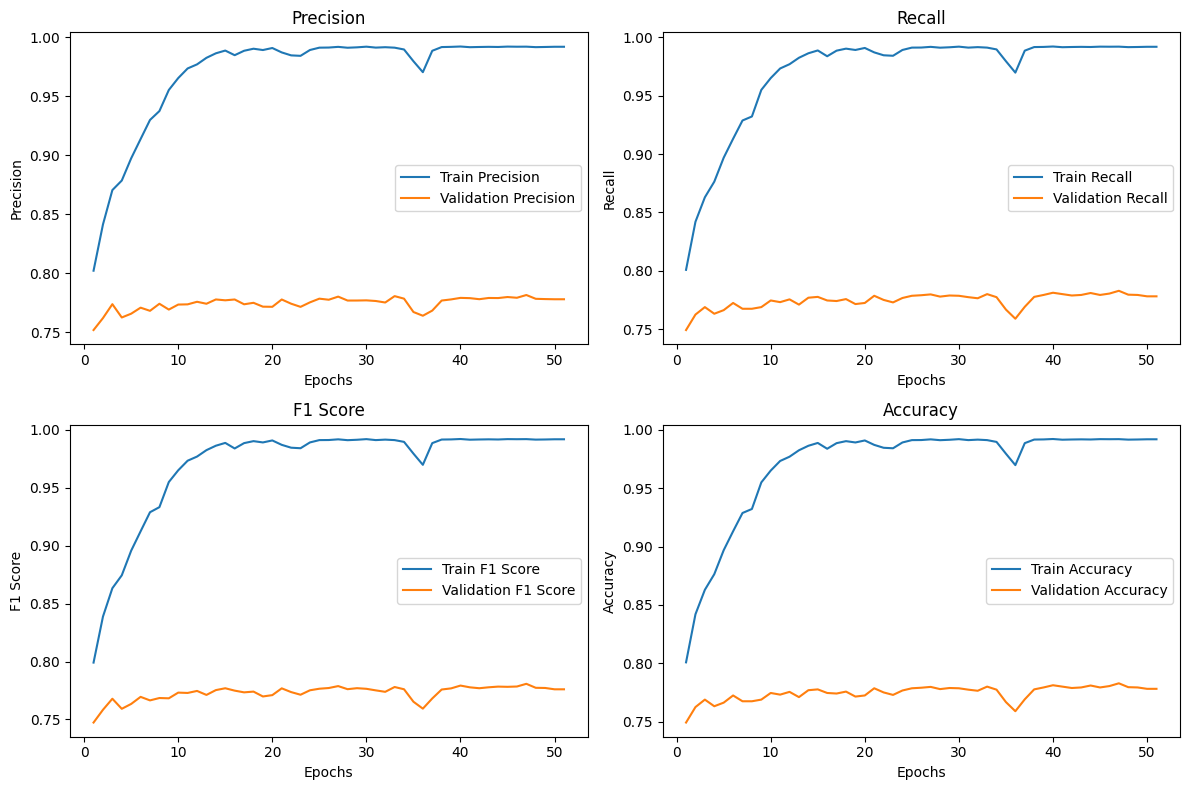

In [ ]:
pipeline_RNN.plot_metrics()

### Model 3: Bidirectional Encoder Representations from Transformers (BERT)

In [ ]:
# Load dataset
dataset = ds  # load_dataset("zeroshot/twitter-financial-news-topic")

# Merge train and validation splits, then split into train (80%), validation (10%), and test (10%)
combined_dataset = concatenate_datasets([dataset['train'], dataset['validation']])

split_dataset = combined_dataset.train_test_split(test_size=0.2)
train_data = split_dataset["train"]
validation_test_data = split_dataset["test"]

split_validation_test = validation_test_data.train_test_split(test_size=0.5)
validation_data = split_validation_test["train"]
test_data = split_validation_test["test"]


# Define topics mapping
topics = {
    "LABEL_0": "Analyst Update",
    "LABEL_1": "Fed | Central Banks",
    "LABEL_2": "Company | Product News",
    "LABEL_3": "Treasuries | Corporate Debt",
    "LABEL_4": "Dividend",
    "LABEL_5": "Earnings",
    "LABEL_6": "Energy | Oil",
    "LABEL_7": "Financials",
    "LABEL_8": "Currencies",
    "LABEL_9": "General News | Opinion",
    "LABEL_10": "Gold | Metals | Materials",
    "LABEL_11": "IPO",
    "LABEL_12": "Legal | Regulation",
    "LABEL_13": "M&A | Investments",
    "LABEL_14": "Macro",
    "LABEL_15": "Markets",
    "LABEL_16": "Politics",
    "LABEL_17": "Personnel Change",
    "LABEL_18": "Stock Commentary",
    "LABEL_19": "Stock Movement",
}


In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=len(topics),
    ignore_mismatched_sizes=True  # Ignore mismatch in classifier layer
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)


# Tokenize data
def tokenize_and_map_labels(batch):
    tokenized = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
    tokenized["labels"] = batch["label"]  # Use numeric labels for training
    return tokenized

train_data = train_data.map(tokenize_and_map_labels, batched=True)
validation_data = validation_data.map(tokenize_and_map_labels, batched=True)
test_data = test_data.map(tokenize_and_map_labels, batched=True)

# Prepare DataLoader
batch_size = 16
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
validation_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
epochs = 1
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([20]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16885 [00:00<?, ? examples/s]

Map:   0%|          | 0/2111 [00:00<?, ? examples/s]

Map:   0%|          | 0/2111 [00:00<?, ? examples/s]

In [ ]:

# Training loop
training_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    start_time = time.time()

    # Training phase
    for batch in train_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in validation_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(validation_loader)
    validation_losses.append(avg_val_loss)

    # Print epoch summary
    end_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(classification_report(all_labels, all_predictions, target_names=list(topics.values())))
    print(f"Epoch {epoch + 1} completed in {(end_time - start_time) / 60:.2f} minutes\n")


In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluation function
def evaluate(data_loader, model, device, topics):

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(all_labels, all_preds, target_names=list(topics.values())))

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=topics.values(), yticklabels=topics.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate on the test set
evaluate(test_loader, model, device, topics)

In [ ]:
# Evaluation metrics summary
def print_metrics():
    print("Training Metrics:")
    evaluate(train_loader, model, device, topics)
    print("\nTest Metrics:")
    evaluate(test_loader, model, device, topics)

# Print training and test metrics
print_metrics()